## 1. Involved vs Informational - Count of Occurence Analysis

_Ekaterina Levitskaya, Kara Kedrick, and Russell J Funk. "Investigating  writing style as a contributor to gender gaps in science and technology”. In: arXiv (2022). doi: 10.48550/arxiv.2204.13805. eprint: 2204.13805._

Involved features: emphasizing relationships
- pronouns (personal, possessive, wh-pronoun)
- non-phrasal coordination ("and")
- questions

Informational features: emphasizing facts
- determiners (predeterminers, wh-determiers, determiners) --> no stop word removal!
- verbs in past tense
- cardinal numbers

involved rate: (n_pron+n_and+n_q)/N_tokens * 100
informational rate: (n_det+n_pas+n_num)/N_tokens * 100
inv-inf-ratio: involved rate / informational rate

Method:
- segmenting into sentences unsing SaT model (https://arxiv.org/abs/2406.16678) and wtsplit https://github.com/segment-any-text/wtpsplit
- detecting questions using

Concatenating all prompts from on user first, then computing scores.
Otherwise, if computing scores per individual prompt:

    - This approach treats each prompt as an _independent_ observation, but in reality, prompts from the same user are correlated (not independent).
    - The within-user variation gets mixed with between-user variation, increasing "noise" and inflating the standard error.
    - When you aggregate scores _after_ scoring, you're averaging numbers that are already affected by token count normalization and variance-stabilizing effects.
    - When performing statistical tests (like a t-test) at the prompt level, the repeated-measures structure (many prompts per user) is _ignored_, which "dilutes" between-group (gender) differences with within-group variation.
    - This makes it **harder to see a significant difference** — standard errors are larger than they should be, so statistical power is lower.


In [1]:
import sqlite3
import pandas as pd

from helpers.occurences import count_occurrences

conn = sqlite3.connect("../../giicg.db")

prompts = pd.read_sql("Select * from expanded_prompts", conn)
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
756,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
757,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de
758,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de
759,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


In [2]:
from helpers.normalization import remove_punctuation_and_newlines, remove_capitalization

prompts['conversational'] = prompts['conversational'].apply(remove_punctuation_and_newlines)
prompts['conversational'] = prompts['conversational'].apply(remove_capitalization)
prompts

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...",parsing data from python iterator how it could...,,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,write shortest tutorial on creating rag on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is faiss,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,transform given code to process large mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
756,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code i want to get nodes and edges ...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
757,1845,37,user,\n nun möchte ich judgement balancing m...,now i want to bring judgement balancing into t...,,,Woman (cisgender),29,de
758,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,i do not see any change in the plot,,,Woman (cisgender),29,de
759,1849,2,user,\n I am working on the problem of reconstru...,i am working on the problem of reconstruc...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


In [3]:
import spacy
import torch
import re
from wtpsplit import SaT
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from helpers.occurences import count_occurrences


def load_spacy_lanuage_model() -> spacy.language.Language:
    try:
        return spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading missing model...")
        spacy.cli.download("en_core_web_sm")
        return spacy.load("en_core_web_sm")


def load_segmentation_model():
    return SaT("sat-3l-sm")


def load_question_detection_model():
    tokenizer = AutoTokenizer.from_pretrained("mrsinghania/asr-question-detection")
    model = AutoModelForSequenceClassification.from_pretrained("mrsinghania/asr-question-detection")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print("question model loaded")
    return tokenizer, model, device


def is_question(text: str, tokenizer, model, device) -> bool:
    if not isinstance(text, str) or text.strip() == "":
        return False
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    is_question = predicted_class == 1
    return is_question


def get_pronoun_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    pronouns = [token.text for token in doc if token.pos_ == "PRON"]
    print("prnouns:", pronouns)
    return len(pronouns)


def get_and_count(text: str) -> int:
    matches = re.findall(r'\band\b', text)
    count = len(matches)
    print("and count:", count)
    return count


def get_determiner_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.tag_ == "DT":  # Regular determiners (includes "the", "a", "my")
            count += 1
        elif token.tag_ == "PDT":  # Predeterminers (e.g., "all", "such")
            count += 1
        elif token.tag_ == "WDT":  # WH-determiners (e.g., "which", "whatever")
            count += 1
    print("determiner count:", count)
    return count


def get_verb_past_tense_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.lower_ == "could":
            continue  # Skip "could"
        if token.tag_ == "VBD" or token.tag_ == "VBN":
            count += 1
    print("verb past tense count:", count)
    return count


def get_number_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.pos_ == "NUM": count += 1
    print("number count:", count)
    return count


def get_question_count(text: str, tokenizer, model, device, sat) -> int:
    segmented = sat.split(text)
    count = 0
    for sentence in segmented:
        if is_question(sentence, tokenizer, model, device):
            count += 1
    print("question count:", count)
    return count


def compute_involved(text: str, tokenizer, model, device, sat, spacy_model) -> float:
    print("computing involved score for text: ", text, " ...")
    tokens = spacy_model(text)
    n_pronoun = get_pronoun_count(text, spacy_model)
    print("n_pronoun:", n_pronoun)
    n_and = get_and_count(text)
    print("n_and:", n_and)
    n_question = get_question_count(text, tokenizer, model, device, sat)
    print("n_question:", n_question)
    score = ((n_pronoun + n_and + n_question) / len(tokens)) * 100
    print("involved score:", score)
    return score


def compute_informational(text: str, spacy_model) -> float:
    print("computing informational score for text: ", text, " ...")
    tokens = spacy_model(text)
    n_determiner = get_determiner_count(text, spacy_model)
    n_verb_past_tense = get_verb_past_tense_count(text, spacy_model)
    n_number = get_number_count(text, spacy_model)
    score = ((n_determiner + n_verb_past_tense + n_number) / len(tokens)) * 100
    print("informational score:", score)
    return score


def compute_inv_inf_ratio(inv: float, inf: float) -> float:
    if inf == 0:
        return inv
    return inv / inf

tokenizer, question_model, device = load_question_detection_model()
spacy_model = load_spacy_lanuage_model()
sat = load_segmentation_model()

def compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model):
    prompts['n_tokens'] = prompts['conversational'].apply(lambda x: len(x.split()))

    prompts['n_det'] = prompts.apply(lambda row: (get_determiner_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_past_tense'] = prompts.apply(lambda row: (get_verb_past_tense_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_numbers'] = prompts.apply(lambda row: (get_number_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_pronouns'] = prompts.apply(lambda row: (get_pronoun_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_and'] = prompts.apply(lambda row: (count_occurrences(row['conversational'], "and", True)/row['n_tokens'])*100, axis=1)
    prompts['n_questions'] = prompts.apply(lambda row: (get_question_count(row['conversational'], tokenizer, question_model, device, sat)/row['n_tokens'])*100, axis=1)

    prompts['involved'] = prompts.apply(lambda row: (row['n_pronouns'] + row['n_and'] + row['n_questions']), axis=1)
    prompts['informational'] = prompts.apply(lambda row: (row['n_det'] + row['n_past_tense'] + row['n_numbers']), axis=1)
    prompts['inv_inf'] = prompts.apply(lambda row: compute_inv_inf_ratio(row['involved'], row['informational']) , axis=1)

    return prompts



question model loaded


# Group per user

In [ ]:
prompts = compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model)

filtered= prompts[prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]
columns = ['involved', 'informational', 'inv_inf', 'n_det', 'n_past_tense', 'n_numbers', 'n_pronouns', 'n_and', 'n_questions']
user_means = (
    filtered.groupby(['user_id', 'gender'])[columns].mean().reset_index()
)
user_means

## Concatenate per user first

determiner count: 19
determiner count: 5
determiner count: 25
determiner count: 5
determiner count: 75
determiner count: 15
determiner count: 90
determiner count: 9
determiner count: 15
determiner count: 195
determiner count: 11
determiner count: 132
determiner count: 26
determiner count: 91
determiner count: 14
determiner count: 10
determiner count: 4
determiner count: 10
determiner count: 396
determiner count: 55
determiner count: 104
determiner count: 25
determiner count: 43
determiner count: 8
determiner count: 51
determiner count: 33
determiner count: 167
determiner count: 22
verb past tense count: 7
verb past tense count: 0
verb past tense count: 3
verb past tense count: 0
verb past tense count: 12
verb past tense count: 2
verb past tense count: 13
verb past tense count: 2
verb past tense count: 5
verb past tense count: 41
verb past tense count: 4
verb past tense count: 27
verb past tense count: 0
verb past tense count: 27
verb past tense count: 5
verb past tense count: 0
verb pa

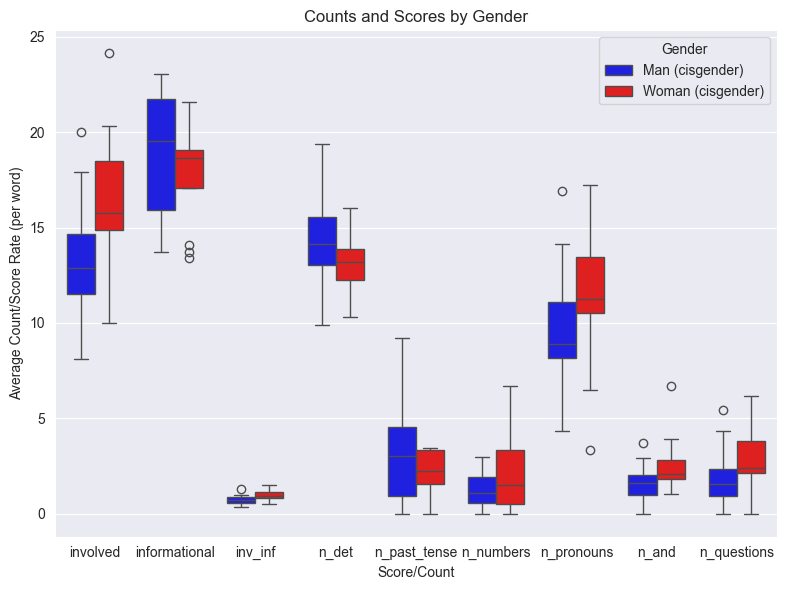

involved:
  Female: n=13, variance=13.8020
  Male:   n=15, variance=10.7534
Normality test (Shapiro-Wilk) for involved:
  Female: stat=0.9771, p-value=0.9623 (normal)
  Male:   stat=0.9621, p-value=0.7284 (normal)
Both distributions are normal, so we can run a t-test.
  T-statistic: -2.4532, p-value: 0.0217
informational:
  Female: n=13, variance=6.4930
  Male:   n=15, variance=12.2204
Normality test (Shapiro-Wilk) for informational:
  Female: stat=0.9062, p-value=0.1625 (normal)
  Male:   stat=0.8812, p-value=0.0495 (not normal)
At least one of the distributions is not normal, so we cannot run a t-test.
Mann-Whitney U test: stat=119.0000, p-value=0.3334
inv_inf:
  Female: n=13, variance=0.0893
  Male:   n=15, variance=0.0541
Normality test (Shapiro-Wilk) for inv_inf:
  Female: stat=0.9694, p-value=0.8869 (normal)
  Male:   stat=0.9575, p-value=0.6484 (normal)
Both distributions are normal, so we can run a t-test.
  T-statistic: -2.2785, p-value: 0.0325
n_det:
  Female: n=13, variance=

In [6]:
from helpers.statistical_tests import run_t_test_on_gender, compare_genders
import matplotlib.pyplot as plt
import seaborn as sns

user_prompts = (
    prompts.groupby(['user_id', 'gender'])['conversational']
    .apply(' '.join)
    .reset_index()
)

user_prompts= user_prompts[user_prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

user_prompts = compute_scores(user_prompts, tokenizer, question_model, device, sat, spacy_model)

columns = ['involved', 'informational', 'inv_inf', 'n_det', 'n_past_tense', 'n_numbers', 'n_pronouns', 'n_and', 'n_questions']

melted = user_prompts.melt(
    id_vars=['user_id', 'gender'],
    value_vars=columns,
    var_name='Score/Count',
    value_name='Normalized Rate'
)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Score/Count',
    y='Normalized Rate',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)

plt.title('Counts and Scores by Gender')
plt.ylabel('Average Count/Score Rate (per word)')
plt.xlabel('Score/Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()




## Statistical Tests

In [11]:
from statsmodels.stats.multitest import multipletests

p_vals = []
for col in columns:
    p_vals.append(compare_genders(user_prompts, col))
reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

for column, raw, corrected, rej in zip(columns, p_vals, pvals_corrected, reject):
    print(f"{column}: raw p={raw:.4f}, FDR: {corrected:.4f}")


involved:
  Female: n=13, variance=13.8020
  Male:   n=15, variance=10.7534
Normality test (Shapiro-Wilk) for involved:
  Female: stat=0.9771, p-value=0.9623 (normal)
  Male:   stat=0.9621, p-value=0.7284 (normal)
Both distributions are normal, so we can run a t-test.
  T-statistic: -2.4532, p-value: 0.0217
informational:
  Female: n=13, variance=6.4930
  Male:   n=15, variance=12.2204
Normality test (Shapiro-Wilk) for informational:
  Female: stat=0.9062, p-value=0.1625 (normal)
  Male:   stat=0.8812, p-value=0.0495 (not normal)
At least one of the distributions is not normal, so we cannot run a t-test.
Mann-Whitney U test: stat=119.0000, p-value=0.3334
inv_inf:
  Female: n=13, variance=0.0893
  Male:   n=15, variance=0.0541
Normality test (Shapiro-Wilk) for inv_inf:
  Female: stat=0.9694, p-value=0.8869 (normal)
  Male:   stat=0.9575, p-value=0.6484 (normal)
Both distributions are normal, so we can run a t-test.
  T-statistic: -2.2785, p-value: 0.0325
n_det:
  Female: n=13, variance=